In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
actor_movies_ratings = pd.read_csv("actor_movies_ratings.csv").drop_duplicates(subset=['tconst','nconst'])
print(actor_movies_ratings.shape)
actor_movies_ratings.head(3)

(313009, 13)


,tconst,ordering,nconst,category,job,characters,averageRating,numVotes,primaryTitle,startYear,region,primaryName,birthYear
0,tt0035423,2,nm0413168,actor,\N,"[""Leopold""]",6.4,88860,Kate & Leopold,2001.0,US,Hugh Jackman,1968
2,tt0120903,2,nm0413168,actor,\N,"[""Logan""]",7.3,644121,X-Men,2000.0,US,Hugh Jackman,1968
8,tt0180037,2,nm0413168,actor,\N,"[""Jack Willis""]",6.4,2344,Paperback Hero,1999.0,US,Hugh Jackman,1968


In [18]:
do_not_include = [ 'Ajay Devgn', 'Irrfan Khan',
       'Prakash Raj','Paresh Rawal', 'Amitabh Bachchan',
       'Aamir Khan', 'Akshay Kumar','Anupam Kher',  'Nassar'
       , 'Shah Rukh Khan','Sumit Keshri', 'Gaurav Manaktala', 'Suryakanth']

actor_movies_filtered = actor_movies_ratings[(actor_movies_ratings['numVotes']>=10000)
                                             &(actor_movies_ratings['averageRating']>=7)
                                             &(~actor_movies_ratings['primaryName'].isin(do_not_include))].copy()
actor_movies_filtered.shape

(21416, 13)

In [38]:
all_years = actor_movies_filtered[['startYear']].drop_duplicates().sort_values('startYear')
all_years.head(3)

,startYear
406,1980.0
930,1981.0
1120,1982.0


In [22]:
actor_movies_filtered['total_hit_movies'] = actor_movies_filtered.groupby('primaryName')['tconst'].transform('nunique')

In [23]:
actors_filtered = actor_movies_filtered[actor_movies_filtered['total_hit_movies']>=15].sort_values('total_hit_movies', ascending=True).copy()
actors_filtered.head(3)

,tconst,ordering,nconst,category,job,characters,averageRating,numVotes,primaryTitle,startYear,region,primaryName,birthYear,total_hit_movies
97992,tt0446755,2,nm0001570,actor,\N,"[""Walter Fane""]",7.4,95783,The Painted Veil,2006.0,US,Edward Norton,1969,15
32844,tt0372784,5,nm0000553,actor,\N,"[""Ducard""]",8.2,1571022,Batman Begins,2005.0,US,Liam Neeson,1952,15
32842,tt0362269,1,nm0000553,actor,\N,"[""Alfred Kinsey""]",7.1,50877,Kinsey,2004.0,US,Liam Neeson,1952,15


In [35]:
all_actors = actors_filtered[['primaryName','birthYear']].drop_duplicates()
all_actors.head(3)

,primaryName,birthYear
97992,Edward Norton,1969
32844,Liam Neeson,1952
114215,Colin Farrell,1976


In [39]:
all_years['key'] = 0
all_actors['key'] = 0
all_years_all_actors = all_years.merge(all_actors, on='key', how='outer')

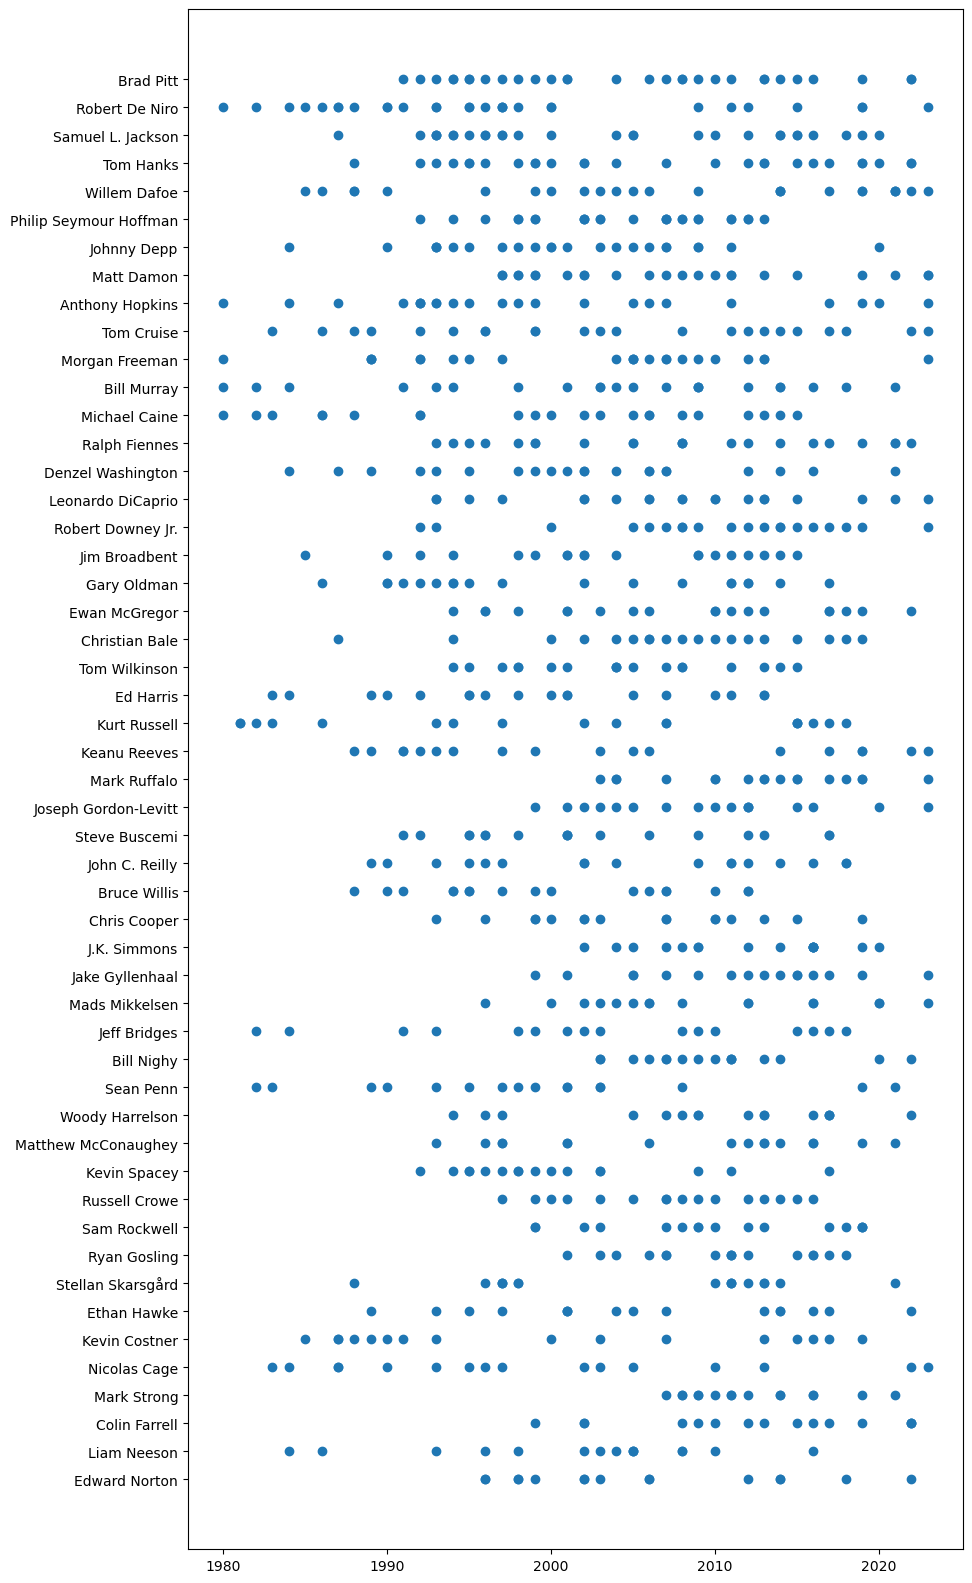

In [40]:
fig, ax = plt.subplots(figsize=(10,20))
ax.scatter(actors_filtered['startYear'], actors_filtered['primaryName'])

In [66]:
actors_filtered_agg = actors_filtered.groupby(['startYear','primaryName']).agg(averageRating=('averageRating','mean')
                                                                               ,numVotes=('numVotes','mean')
                                                                               ,primaryTitle=('primaryTitle',list)).reset_index()
actors_filtered_agg.head(3)

,startYear,primaryName,averageRating,numVotes,primaryTitle
0,1980.0,Anthony Hopkins,8.2,257411.0,[The Elephant Man]
1,1980.0,Bill Murray,7.2,126696.0,[Caddyshack]
2,1980.0,Michael Caine,7.1,47946.0,[Dressed to Kill]


In [67]:
actors_with_all_years = all_years_all_actors.merge(actors_filtered_agg[['startYear','primaryName','averageRating','numVotes','primaryTitle']]
                           , how='left', on=['startYear','primaryName']).drop(labels='key', axis=1)

actors_with_all_years['has_movie'] = ~actors_with_all_years['primaryTitle'].isna()

In [68]:
actors_with_all_years_sorted = actors_with_all_years.sort_values(['primaryName','startYear'])

In [69]:
actors_with_all_years_sorted['startYear'] = actors_with_all_years_sorted['startYear'].astype(int)
actors_with_all_years_sorted['birthYear'] = actors_with_all_years_sorted['birthYear'].astype(int)
actors_with_all_years_sorted['age_at_movie'] = actors_with_all_years_sorted['startYear']-actors_with_all_years_sorted['birthYear']

In [91]:
actors_with_all_years_sorted['rolling_5yr_movies'] = actors_with_all_years_sorted.groupby('primaryName')['has_movie'].transform(lambda s: s.rolling(5, min_periods=1).sum())
actors_with_all_years_sorted['rolling_5yr_avgrating'] = actors_with_all_years_sorted.groupby('primaryName')['averageRating'].transform(lambda s: s.rolling(5, min_periods=1).mean())
actors_with_all_years_sorted['rolling_5yr_sumrating'] = actors_with_all_years_sorted.groupby('primaryName')['averageRating'].transform(lambda s: s.rolling(5, min_periods=1).sum())

In [92]:
actors_with_all_years_sorted.head(10)

,startYear,primaryName,birthYear,averageRating,numVotes,primaryTitle,has_movie,age_at_movie,rolling_5yr_movies,rolling_5yr_avgrating,rolling_5yr_sumrating
42,1980,Anthony Hopkins,1937,8.2,257411.0,[The Elephant Man],True,43,1.0,8.2,8.2
93,1981,Anthony Hopkins,1937,NaN,NaN,NaN,False,44,1.0,8.2,8.2
144,1982,Anthony Hopkins,1937,NaN,NaN,NaN,False,45,1.0,8.2,8.2
195,1983,Anthony Hopkins,1937,NaN,NaN,NaN,False,46,1.0,8.2,8.2
246,1984,Anthony Hopkins,1937,7.0,30159.0,[The Bounty],True,47,2.0,7.6,15.2
297,1985,Anthony Hopkins,1937,NaN,NaN,NaN,False,48,1.0,7.0,7.0
348,1986,Anthony Hopkins,1937,NaN,NaN,NaN,False,49,1.0,7.0,7.0
399,1987,Anthony Hopkins,1937,7.4,11154.0,[84 Charing Cross Road],True,50,2.0,7.2,14.4
450,1988,Anthony Hopkins,1937,NaN,NaN,NaN,False,51,2.0,7.2,14.4
501,1989,Anthony Hopkins,1937,NaN,NaN,NaN,False,52,1.0,7.4,7.4


(6.5, 8.0)

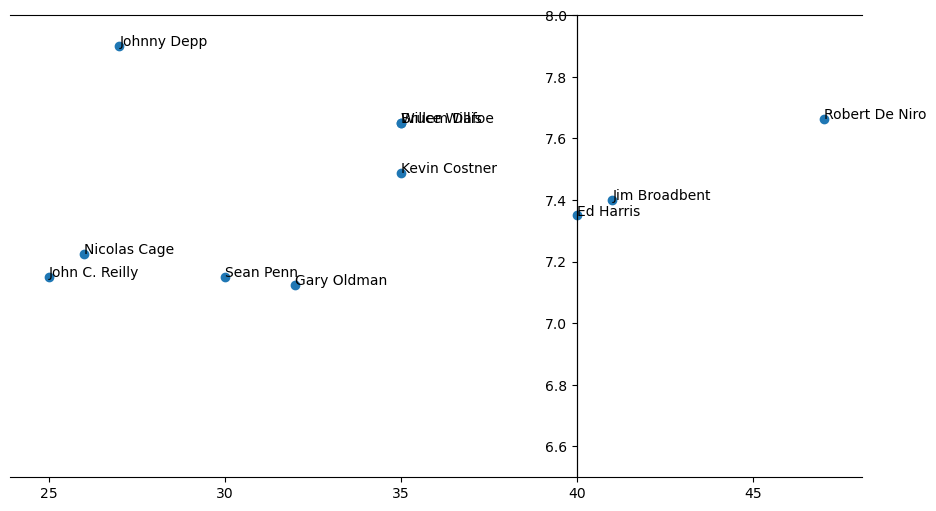

In [93]:
one_year = 1990
one_year_actors = actors_with_all_years_sorted[(actors_with_all_years_sorted['startYear']==one_year)&(actors_with_all_years_sorted['has_movie']==1)].copy()
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(one_year_actors['age_at_movie'], one_year_actors['rolling_5yr_avgrating'])

for idx, row in one_year_actors.iterrows():
    ax.annotate(row['primaryName'], (row['age_at_movie'], row['rolling_5yr_avgrating']))

ax.spines['left'].set_position(('data', 40))
ax.spines['right'].set_position(('data', 40))
ax.set_ylim(ymin=6.5, ymax=8)

In [108]:
@interact(one_year=widgets.IntSlider(min=1980, max=2024, step=1, value=1980))
def get_one_year(one_year):
    one_year_actors = (actors_with_all_years_sorted[(actors_with_all_years_sorted['startYear']==one_year)
                                                #    &(actors_with_all_years_sorted['has_movie']==1)
                                                   ].copy())
    fig, ax = plt.subplots(figsize=(11,6))
    ax.scatter(one_year_actors['age_at_movie'], one_year_actors['rolling_5yr_sumrating'])

    for idx, row in one_year_actors.iterrows():
        ax.annotate(row['primaryName'], (row['age_at_movie'], row['rolling_5yr_sumrating']))

    year_title = ax.annotate(f"Year {one_year}",(40,38), fontsize=16, ha='center', fontweight='bold')
    year_title.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white'))

    ax.spines['left'].set_position(('data', 40))
    ax.spines['right'].set_position(('data', 40))
    ax.set_ylim(ymin=7, ymax=actors_with_all_years_sorted['rolling_5yr_sumrating'].max())
    ax.set_xlim(xmin=20, xmax=70)

interactive(children=(IntSlider(value=1980, description='one_year', max=2024, min=1980), Output()), _dom_class…